# Machine Learning

In [29]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt


import cv 
import importlib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as PipelineIMB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import utils

import joblib

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from tensorflow.keras import callbacks
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation



In [30]:
pd.set_option("display.max_colwidth", None)

In [31]:
data = pd.read_csv("dados/pos_analyse.csv", encoding='latin1')

In [32]:
data.drop("Unnamed: 0", axis=1, inplace= True)

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
#data = data.dropna(subset=["AVERAGE_SPEED_DIFF_N"])

data.shape

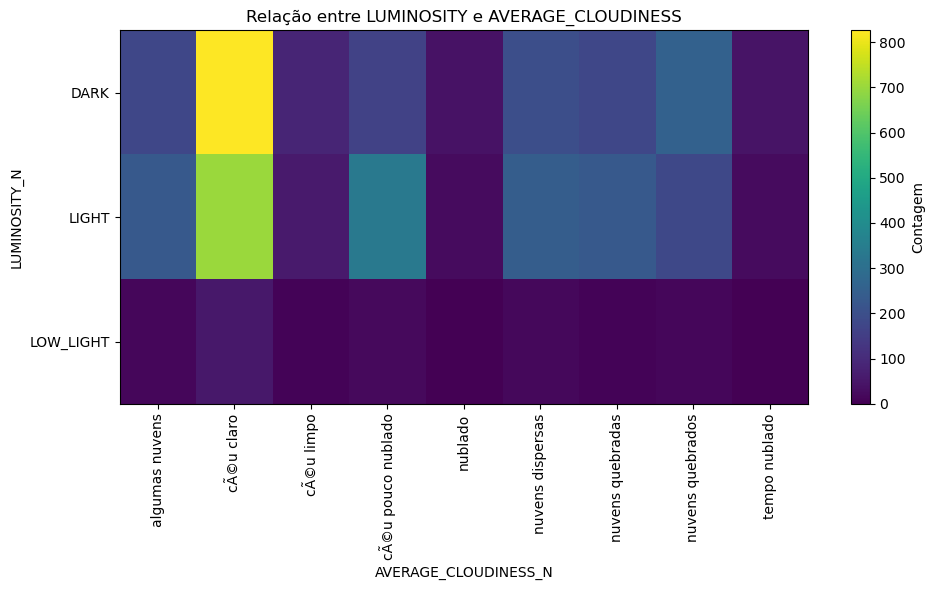

In [33]:
ct = pd.crosstab(data["LUMINOSITY"], data["AVERAGE_CLOUDINESS"])

plt.figure(figsize=(10, 6))
plt.imshow(ct, aspect='auto')
plt.colorbar(label='Contagem')

plt.xticks(range(len(ct.columns)), ct.columns, rotation=90)
plt.yticks(range(len(ct.index)), ct.index)

plt.xlabel("AVERAGE_CLOUDINESS_N")
plt.ylabel("LUMINOSITY_N")
plt.title("Relação entre LUMINOSITY e AVERAGE_CLOUDINESS")

plt.tight_layout()
plt.show()

In [34]:

def preencher_cloudiness(row):
    if pd.notna(row["AVERAGE_CLOUDINESS_N"]):
        return row["AVERAGE_CLOUDINESS_N"]
    
    if row["LUMINOSITY_N"] == 2: # light
        return 1   # céu claro
    
    if row["LUMINOSITY_N"] == 0: # dark
        return 7   # nublado
    
    if row["LUMINOSITY_N"] == 1: #LOW_LIGHT
        return 3 # algumas nuvens

data["AVERAGE_CLOUDINESS_N"] = data.apply(preencher_cloudiness, axis=1)


In [ ]:
data.isna().sum()

In [35]:
data["record_date"] = pd.to_datetime(data["record_date"])

In [36]:
data = data.sort_values(by='record_date')


In [ ]:
data.columns

### Treino e Teste

In [37]:
X =  data[['record_date','AVERAGE_FREE_FLOW_SPEED',
       'AVERAGE_TIME_DIFF', 'AVERAGE_FREE_FLOW_TIME',
       'AVERAGE_TEMPERATURE', 'AVERAGE_ATMOSP_PRESSURE', 'AVERAGE_HUMIDITY',
       'AVERAGE_WIND_SPEED', 'year', 'month', 'day',
       'hour', 'weekday', 'is_weekend', 'is_holiday', 'season', 'LUMINOSITY_N', 'AVERAGE_CLOUDINESS_N',
       'is_peak_hour', 'poor_visibility', 'hour_weekday', 'time_ratio']]

y = data['AVERAGE_SPEED_DIFF_N']

#X = X.dropna()
#y = y.loc[X.index]

# Time-Based Split 
# cutoff = data['record_date'].quantile(0.70)  
# train_mask = data['record_date'] <= cutoff

# X_train, X_test = X[train_mask], X[~train_mask]
# y_train, y_test = y[train_mask], y[~train_mask]

# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = n, stratify=y)

# print(f"Datas do treino: {data[train_mask]['record_date'].min()} a {data[train_mask]['record_date'].max()}")
# print(f"Datas do teste: {data[~train_mask]['record_date'].min()} a {data[~train_mask]['record_date'].max()}")

# Time-Based Split
cutoff = data['record_date'].quantile(0.70)
train_mask = data['record_date'] <= cutoff

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = n, stratify=y)

X_train_full, X_test = X[train_mask], X[~train_mask]
y_train_full, y_test = y[train_mask], y[~train_mask]

cutoff_val = X_train_full['record_date'].quantile(0.80)  
train_mask_inner = X_train_full['record_date'] <= cutoff_val

X_train, X_val = X_train_full[train_mask_inner], X_train_full[~train_mask_inner]
y_train, y_val = y_train_full[train_mask_inner], y_train_full[~train_mask_inner]

#LOOKKK
X_train = X_train.drop(columns='record_date')
X_val = X_val.drop(columns='record_date')
X_test = X_test.drop(columns='record_date')


### Pipeline

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class CatBoostEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = CatBoostEncoder()
    
    def fit(self, X, y):
        self.encoder.fit(X, y)
        return self
    
    def transform(self, X):
        return self.encoder.transform(X)
    
    def fit_transform(self, X, y):
        return self.encoder.fit_transform(X, y)

In [69]:
'''O CatBoostEncoder substitui valores categóricos por uma versão suavizada da média da variável alvo (target mean encoding), levando em consideração a distribuição da variável alvo para evitar overfitting'''

def f_preprocessor ():
    cols_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cols_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()

    pipe_cat = Pipeline([('encoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))])#Pipeline([('encoder', CatBoostEncoderWrapper())])# 
    pipe_num = Pipeline([('std_scaler', StandardScaler())])

    preprocessor = ColumnTransformer([('numeric', pipe_num, cols_num), #'passthrough'
                                    ('categoric', pipe_cat, cols_cat)])
    return preprocessor

preprocessor = f_preprocessor()

### Cross Validation (treino)

In [ ]:
importlib.reload(cv)
df_over = cv.cross_validation_models_set_class('Default', preprocessor, X_train, y_train)
df_over.sort_values('F1-Score', ascending = False)

In [ ]:
importlib.reload(cv)
df_over = cv.cross_validation_models_set_class('Oversampling', preprocessor, X_train, y_train)
df_over.sort_values('F1-Score', ascending = False)

### Tuning

In [ ]:


n = 42

decision_tree_params = {
    'model__criterion': ['gini', 'entropy'],  
    'model__max_depth': [None, 5, 10, 20], 
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4]  
}

random_forest_params = {
    'model__n_estimators': [100, 200],  
    'model__criterion': ['gini', 'entropy'], 
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False] 
}

balanced_random_forest_params = {
    'model__n_estimators': [100, 200],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False],
    'model__sampling_strategy': ['auto', 0.5, 0.75],  # Controle do balanceamento
    'model__replacement': [True, False],  # Amostragem com/sem reposição
    'model__class_weight': [None, 'balanced', 'balanced_subsample']
}

gradient_boosting_params = {
    'model__learning_rate': [0.1, 0.01],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5]
}

logistic_regression_params = {
    'model__C': [0.1, 1, 10],  # regularização
    'model__penalty': ['l1', 'l2'],  # tipo de regularização
    'model__solver': ['liblinear']  
}

# Parâmetros para SVM
svm_params = {
    'model__C': [0.1, 1, 10],  
    'model__kernel': ['linear', 'rbf'],  
    'model__gamma': ['scale', 'auto']  # Coeficiente para kernel 'rbf'
}



knn_params = {
    'model__n_neighbors': [3, 5, 7, 10],  # Número de vizinhos a serem considerados
    'model__weights': ['uniform', 'distance'],  # Peso dado aos vizinhos
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo usado para encontrar os vizinhos
    'model__leaf_size': [20, 30, 40],  # Tamanho das folhas (afeta a eficiência)
    'model__p': [1, 2]  # Tipo de distância (1 = Manhattan, 2 = Euclidiana)
}


# Parâmetros para LightGBM
lightgbm_params = {
    'model__num_leaves': [31, 50, 100],          # Número máximo de folhas em uma árvore
    'model__max_depth': [-1, 5, 10],             # Profundidade máxima (-1 significa sem limite)
    'model__learning_rate': [0.1, 0.01, 0.001],  # Taxa de aprendizado
    'model__n_estimators': [100, 200],           # Número de árvores
    'model__min_child_samples': [20, 50],        # Número mínimo de dados em uma folha
    'model__subsample': [0.8, 1.0],              # Fração de amostras para treino
    'model__colsample_bytree': [0.8, 1.0],       # Fração de features para construir cada árvore
    'model__reg_alpha': [0, 0.1],                # Regularização L1
    'model__reg_lambda': [0, 0.1],               # Regularização L2
    'model__boosting_type': ['gbdt', 'dart']      # Tipo de boosting
}

xgb_params = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [100, 200],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 0.1],
    'model__min_child_weight': [1, 5],
    'model__tree_method': ['hist']  # Faster for medium-sized datasets
}

catboost_params = {
    'model__depth': [8, 10, 12],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__iterations': [100, 200],
    'model__l2_leaf_reg': [3, 5, 7],
    'model__border_count': [64, 96],
    'model__grow_policy': ['SymmetricTree'],  
    'model__auto_class_weights': ['Balanced'], 
    'model__boosting_type': ['Ordered']
}

mlp_params = {
    'model__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'model__activation': ['relu', 'tanh'],  # 'logistic' também é possível
    'model__solver': ['adam'],  
    'model__alpha': [0.0001, 0.001, 0.01],  # Regularização L2
    'model__learning_rate_init': [0.001, 0.01],  # Taxa de aprendizado inicial
    'model__max_iter': [200, 300],
    'model__early_stopping': [True],  # Para evitar overfitting
    'model__random_state': [42]  # Para reprodutibilidade
}

easy_ensemble_params = {
    'model__n_estimators': [10, 30, 50, 100],
    'model__estimator': [DecisionTreeClassifier(max_depth=5)],  # Removed None
    'model__warm_start': [True, False],
    'model__sampling_strategy': ['auto', 0.5, 0.75, 1.0],
    'model__replacement': [True, False],
    'model__random_state': [None, 42],
    'model__estimator__criterion': ['gini', 'entropy'],
    'model__estimator__max_depth': [None, 5, 10],
    'model__estimator__min_samples_split': [2, 5, 10],
    'model__estimator__min_samples_leaf': [1, 2, 4]
}




modelos = {
    #'Gradient Boosting': (GradientBoostingClassifier(random_state=n), gradient_boosting_params),
    #'Regressão Logística': (LogisticRegression(random_state=n, max_iter=1000), logistic_regression_params),
    #'SVM': (SVC(random_state=n, probability=True), svm_params),
    # 'KNN': (KNeighborsClassifier(), knn_params),
    #'MLP' : (MLPClassifier(),mlp_params),
    'XGBoost': (XGBClassifier(random_state=n), xgb_params),
    'LightGBM': (LGBMClassifier(random_state=n), lightgbm_params)
    #'Decision Tree': (DecisionTreeClassifier(random_state=n), decision_tree_params)
    #'Random Forest': (RandomForestClassifier(random_state=n), random_forest_params),
    #'CatBoost': (CatBoostClassifier(random_state=n, verbose=0, auto_class_weights='Balanced'), catboost_params),
    #'Balanced Random Forest': (BalancedRandomForestClassifier(random_state=n), balanced_random_forest_params),
    #'Easy Ensemble': (EasyEnsembleClassifier(random_state=42), easy_ensemble_params)

}


In [ ]:
importlib.reload(cv)
gs = cv.hyperparameter_optimization(None,preprocessor, X_train, y_train, modelos)

In [ ]:
gs

In [ ]:
importlib.reload(cv)
gs = cv.hyperparameter_optimization(SMOTE(),preprocessor, X_train, y_train, modelos)

In [ ]:
gs

### Teste

In [70]:
n = 42

#{'model__auto_class_weights': 'Balanced', 'model__boosting_type': 'Ordered', 'model__border_count': 64, 'model__depth': 10, 'model__grow_policy': 'SymmetricTree', 'model__iterations': 100, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.2}

catboost = CatBoostClassifier(
    auto_class_weights='Balanced',
    depth=8,  # ↓ Reduzido de 10 para 6-8
    learning_rate=0.02,  # ↓ Reduzido de 0.2 para 0.05-0.1
    iterations=2000,
    border_count=32,
    min_data_in_leaf=200,
    boosting_type='Plain',
    grow_policy='SymmetricTree',
    l2_leaf_reg=150,  # ↑ Aumentado de 50 para 100-200
    od_type='Iter',
    od_wait=100,  # ↑ Mais paciência
    verbose=True,
    rsm=0.9,  # ↑ Mais features por split
    bootstrap_type='Bayesian',  # ← Mudado para Bayesian
    random_strength=0.5,  # ↑ Mais ruído
    use_best_model=True,
    eval_metric='MultiClass'  # ← Especificar métrica
)



pipe_cb = PipelineIMB([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE()),
    ('model', catboost)
])

#{'model__bootstrap': True, 'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
randomforest = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_depth =20, min_samples_leaf =2, min_samples_split= 2, n_estimators= 200)
pipe_rf = PipelineIMB([
    ('preprocessor', preprocessor),
    ('model', randomforest)
])

balancedrandomforest= BalancedRandomForestClassifier(class_weight = None, criterion= 'gini', max_depth =10, min_samples_leaf = 2, min_samples_split= 2, n_estimators =100, replacement =True, sampling_strategy='auto',
                                                     bootstrap=True, oob_score=True)
pipe_brf =PipelineIMB([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE()),
    ('model', balancedrandomforest)
])


lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    boosting_type='gbdt',

    # Complexidade da árvore
    max_depth=8,           # parecido com CatBoost depth=8
    num_leaves=40,         # reduz overfitting

    # Regularização (equivalente l2_leaf_reg alto do CatBoost)
    reg_alpha=5,           # L1
    reg_lambda=150,        # L2 forte

    # Aprendizado
    learning_rate=0.02,    # igual ao CatBoost
    n_estimators=2000,     # igual iterations=2000

    # Frequência de amostragem
    subsample=0.7,         # igual subsample do CB
    colsample_bytree=0.9,  # igual rsm=0.9
    bagging_freq=1,

    # Ruído reduzir overfitting
    min_child_samples=200,  # parecido com min_data_in_leaf=200

    metric='multi_logloss',
    random_state=42,
    verbose=-1
)

pipe_lgbm = PipelineIMB([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE()),
    ('model', lgbm)
])



#### Treinos
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed   = preprocessor.transform(X_val)
#pipe_cb.fit(X_train, y_train,
             #model__eval_set=[(X_val_transformed, y_val)])
#pipe_rf.fit(X_train, y_train)
#pipe_brf.fit(X_train, y_train)

pipe_lgbm.fit(
    X_train, y_train,
    model__eval_set=[
        (X_train_transformed, y_train),
        (X_val_transformed, y_val)
    ],
    model__eval_names=['training', 'valid_0'],
    model__eval_metric='multi_logloss',
    model__callbacks=[
        early_stopping(100),
        log_evaluation(50)
    ]
)


trained = pipe_lgbm.named_steps['model']

history = trained.evals_result_


#print(f"OOB Score: {pipe_rf.named_steps['model'].oob_score_:.4f}")
 


Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.900892	valid_0's multi_logloss: 0.886458
[100]	training's multi_logloss: 0.693151	valid_0's multi_logloss: 0.671748
[150]	training's multi_logloss: 0.609136	valid_0's multi_logloss: 0.58505
[200]	training's multi_logloss: 0.563244	valid_0's multi_logloss: 0.542078
[250]	training's multi_logloss: 0.532708	valid_0's multi_logloss: 0.516704
[300]	training's multi_logloss: 0.510172	valid_0's multi_logloss: 0.501016
[350]	training's multi_logloss: 0.492813	valid_0's multi_logloss: 0.490284
[400]	training's multi_logloss: 0.477992	valid_0's multi_logloss: 0.482191
[450]	training's multi_logloss: 0.466079	valid_0's multi_logloss: 0.476017
[500]	training's multi_logloss: 0.455334	valid_0's multi_logloss: 0.470888
[550]	training's multi_logloss: 0.446066	valid_0's multi_logloss: 0.467256
[600]	training's multi_logloss: 0.437782	valid_0's multi_logloss: 0.463471
[650]	training's multi_logloss: 0.430213

In [ ]:
#catboost
plt.figure(figsize=(10,5))

for key in history['learn']:
    plt.plot(history['learn'][key], label=f'Train {key}')
    
for key in history['validation']:
    plt.plot(history['validation'][key], label=f'Validation {key}')

plt.xlabel('Iteração')
plt.ylabel('Valor da Métrica')
plt.title('Curva de Aprendizado - CatBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

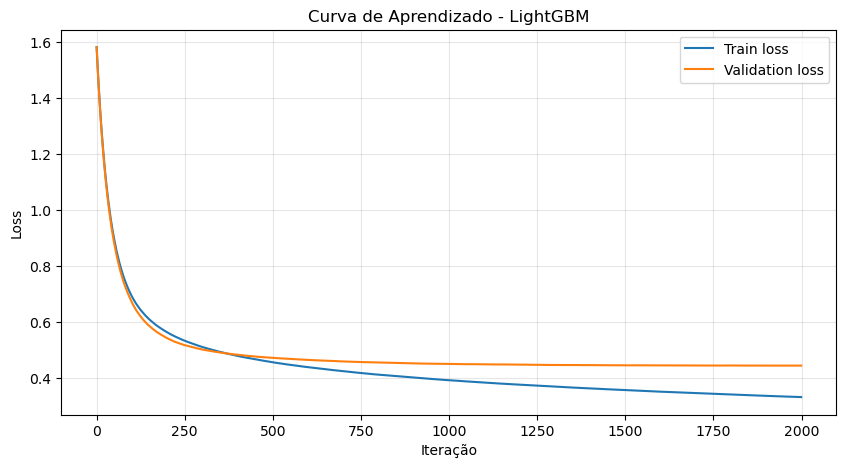

In [71]:
# lightgbm
plt.figure(figsize=(10,5))

plt.plot(history['training']['multi_logloss'], label='Train loss')
plt.plot(history['valid_0']['multi_logloss'], label='Validation loss')

plt.xlabel('Iteração')
plt.ylabel('Loss')
plt.title('Curva de Aprendizado - LightGBM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##### Rede

In [ ]:

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]
n_classes = len(np.unique(y_train))

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# class_weights_ = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = dict(enumerate(class_weights_))
# print("Class weights:", class_weights)

class_weights = {
    0: 0.8,   # ↑ de 0.54 (menos punição)
    1: 1.2,   # ↑ de 1.03 (mais foco)
    2: 1.0,   # ↓ de 0.83 (menos foco)
    3: 1.5,   # ~ igual a 1.50
    4: 2.5    # ↓ de 3.14 (menos foco agressivo)
}



nn_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # MAIS NEURÔNIOS, MENOS REG
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

def train_and_plot_nn_with_early_stop(X_train, y_train, X_val, y_val, model, 
                                     epochs=200, batch_size=32, patience=15):

    # Preparar labels
    if len(np.unique(y_train)) > 2:
        y_train_nn = keras.utils.to_categorical(y_train)
        y_val_nn = keras.utils.to_categorical(y_val)
    else:
        y_train_nn = y_train.reshape(-1, 1)
        y_val_nn = y_val.reshape(-1, 1)
    
    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    # Reduce learning rate on plateau
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
    
    history = model.fit(
        X_train, y_train_nn,
        validation_data=(X_val, y_val_nn),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights, 
        verbose=1
    )
    
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    
    if early_stopping.stopped_epoch > 0:
        best_epoch = early_stopping.stopped_epoch - patience
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
    
    plt.xlabel('Época')
    plt.ylabel('Valor')
    plt.title('Curva de Aprendizado - Rede Neural (com Early Stopping)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    if early_stopping.stopped_epoch > 0:
        print(f"\nEarly stopping at epoch {early_stopping.stopped_epoch}")
        print(f"Best epoch: {early_stopping.stopped_epoch - patience}")
        print(f"Best val_loss: {min(history.history['val_loss']):.4f}")
    
    return model, history

print("Treinando Rede Neural com Early Stopping...")
trained_nn, history_nn = train_and_plot_nn_with_early_stop(
    X_train_processed, y_train,
    X_val_processed, y_val,
    nn_model,
    epochs=200,
    batch_size=32,
    patience=12
)

In [72]:
# predictions_rf = pipe_rf.predict(X_test)
# predictions_p_rf =  pipe_rf.predict_proba(X_test)[:, 1] 

# predictions_cb = pipe_cb.predict(X_test)
# predictions_p_cb =  pipe_cb.predict_proba(X_test)[:, 1]

predictions_lgbm = pipe_lgbm.predict(X_test)
predictions_p_lgbm =  pipe_lgbm.predict_proba(X_test)[:, 1]

# predictions_nn_p = trained_nn.predict(X_test_processed)
# predictions_nn= predictions_nn_p.argmax(axis=1)



c:\Users\emman\miniconda3\envs\DAA\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\emman\miniconda3\envs\DAA\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [73]:
rf_report = classification_report(y_test, predictions_lgbm)
print("Relatório de Classificação RF:")
print(rf_report)

Relatório de Classificação RF:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       514
           1       0.62      0.84      0.71       475
           2       0.82      0.66      0.73       529
           3       0.76      0.78      0.77       379
           4       0.76      0.72      0.74       147

    accuracy                           0.76      2044
   macro avg       0.77      0.76      0.76      2044
weighted avg       0.78      0.76      0.76      2044



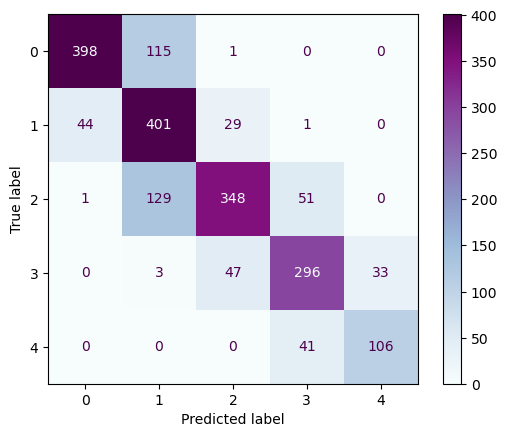

In [74]:
classes = np.unique(y_train)
cm = confusion_matrix(y_test, predictions_lgbm, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classes)
disp = disp.plot(cmap = plt.cm.BuPu)
plt.grid(False)

c:\Users\emman\miniconda3\envs\DAA\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


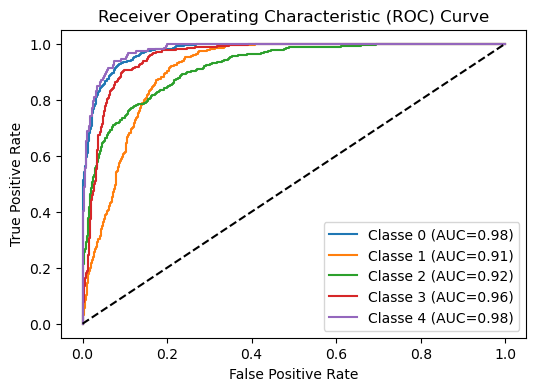

In [75]:
cv.curva_roc(X_test, y_test, pipe_lgbm)

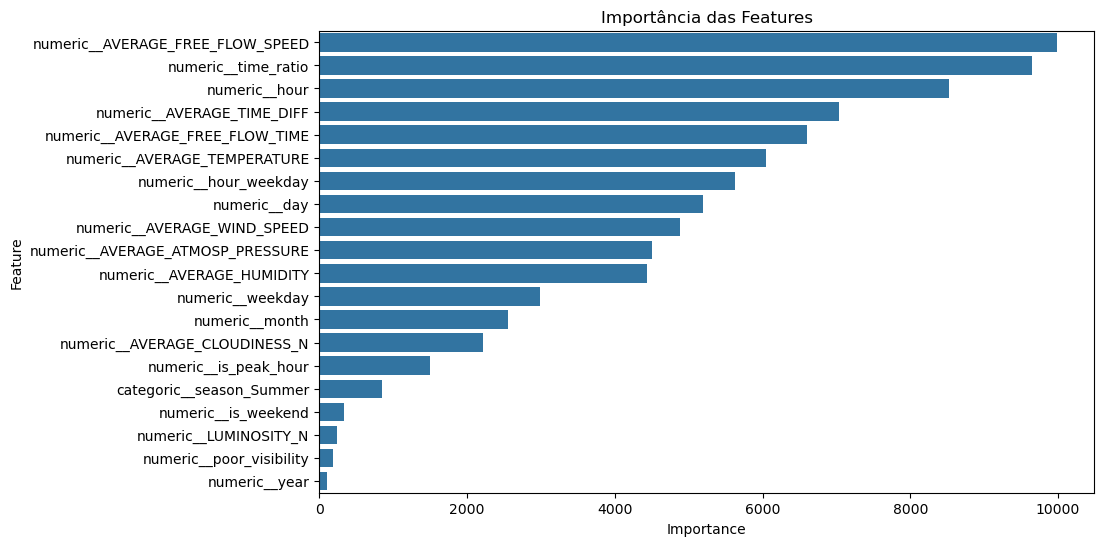

In [76]:
importlib.reload(utils)
#utils.shap_tree(preprocessor, X, X_test, pipe_cb)
utils.feature_importance(pipe_lgbm)

In [ ]:
rf_report = classification_report(y_test, predictions_rf)
print("Relatório de Classificação CB:")
print(rf_report)

In [ ]:
cm = confusion_matrix(y_test, predictions_cb, labels=pipe_cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = pipe_cb.classes_)
disp = disp.plot(cmap = plt.cm.BuPu)
plt.grid(False)

In [ ]:
cv.curva_roc(X_test, y_test, pipe_cb)

In [ ]:
importlib.reload(utils)
#utils.shap_tree(preprocessor, X, X_test, pipe_cb)
utils.feature_importance(pipe_cb)

### Salvar Modelos

In [77]:
pipeline_final = PipelineIMB([('preprocessor', preprocessor), 
                              ('resampler', SMOTE()),
                              ('model', lgbm)])
joblib.dump(pipeline_final, 'modelos/lgbm_c1.pkl')

['modelos/lgbm_c1.pkl']

In [ ]:
pipeline_final = PipelineIMB([('preprocessor', preprocessor), 
                              ('model', catboost)])
joblib.dump(pipeline_final, 'modelos/catboost_c4.pkl')

In [ ]:
pipeline_nn = PipelineIMB([
    ('preprocessor', preprocessor), 
    ('model', trained_nn)  
])

joblib.dump(pipeline_nn, 'modelos/rede_neural_c4.pkl')